In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.mobilenet import MobileNet
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D,BatchNormalization
from keras.applications import ResNet50, MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
from keras.models import Model
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
import argparse


%matplotlib inline

In [ ]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)

        img = cv2.imread(PATH)

        img = cv2.resize(img, (RESIZE,RESIZE))

        IMG.append(np.array(img))
    return IMG

In [ ]:
#load data
early_blight_norm_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/EarlyBlight_Normal',224))
#early_blight_serious_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/EarlyBlight_Serious',224))
late_blight_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/LateBlight',224))
healthy_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/Healthy',224))
#insect_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/Insect',224))
#lrv_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/LeafRoll',224))
#virus_train =np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/Virus',224))

early_blight_norm_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/EarlyBlight_Normal',224))
#early_blight_serious_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/EarlyBlight_Serious',224))
late_blight_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/LateBlight',224))
healthy_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/Healthy',224))
#insect_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/Insect',224))
#lrv_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/LeafRoll',224))
#virus_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/Virus',224))

100%|██████████| 205/205 [00:01<00:00, 109.39it/s]


In [ ]:
# Create labels
early_blight_norm_train_label = np.full(len(early_blight_norm_train),0)
#early_blight_serious_train_label = np.full(len(early_blight_serious_train),1)
late_blight_train_label = np.full(len(late_blight_train),1)
healthy_train_label = np.full(len(healthy_train),2)
#insect_train_label = np.full(len(insect_train),4)
#lrv_train_label = np.full(len(lrv_train),5)
#virus_train_label = np.full(len(virus_train),6)

early_blight_norm_test_label = np.full(len(early_blight_norm_test),0)
#early_blight_serious_test_label = np.full(len(early_blight_serious_test),1)
late_blight_test_label = np.full(len(late_blight_test),1)
healthy_test_label = np.full(len(healthy_test),2)
#insect_test_label = np.full(len(insect_test),4)
#lrv_test_label = np.full(len(lrv_test),5)
#virus_test_label = np.full(len(virus_test),6)

In [ ]:
# Merge data
X_train = np.concatenate((early_blight_norm_train, late_blight_train, healthy_train), axis = 0)
Y_train = np.concatenate((early_blight_norm_train_label, late_blight_train_label, healthy_train_label), axis = 0)
X_test = np.concatenate((early_blight_norm_test, late_blight_test, healthy_test), axis = 0)
Y_test = np.concatenate((early_blight_norm_test_label, late_blight_test_label, healthy_test_label), axis = 0)

In [ ]:
# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

In [ ]:
# To categorical
Y_train = to_categorical(Y_train, num_classes= 3)
Y_test = to_categorical(Y_test, num_classes= 3)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train,
    test_size=0.2,
    random_state=11
)

In [ ]:
BATCH_SIZE = 32

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        shear_range = 0.5,
        width_shift_range=0.4,
        height_shift_range=0.4,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True  # randomly flip images

    )

In [ ]:
IMAGE_SIZE=224
# Model
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
inputs = Input(input_shape)

dennet   = DenseNet201(include_top=False, input_shape=input_shape)(inputs)


In [ ]:
outputs = Concatenate(axis=-1)([GlobalAveragePooling2D()(dennet)])
outputs = Dropout(0.4)(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(128,activation='relu')(outputs)
outputs = Dropout(0.2)(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(3, activation='softmax')(outputs)

model = Model(inputs, outputs)
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(lr=0.0001, decay=0.00001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d (  (None, 1920)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 concatenate (Concatenate)   (None, 1920)              0         
                                                                 
 dropout (Dropout)           (None, 1920)              0         
                                                                 
 batch_normalization (Batch  (None, 1920)              7680      
 Normalization)                                              

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="/content/drive/My Drive/resDenseV16(3_classes).hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [ ]:
history = model.fit(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=30,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

Epoch 1/30
60/60 [==============================] - ETA: 0s - loss: 0.3572 - accuracy: 0.8349

60/60 [==============================] - 88s 743ms/step - loss: 0.3572 - accuracy: 0.8349 - val_loss: 0.1093 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 2/30
60/60 [==============================] - ETA: 0s - loss: 0.1464 - accuracy: 0.9531

60/60 [==============================] - 41s 675ms/step - loss: 0.1464 - accuracy: 0.9531 - val_loss: 0.0337 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 3/30
60/60 [==============================] - ETA: 0s - loss: 0.1164 - accuracy: 0.9552

60/60 [==============================] - 40s 661ms/step - loss: 0.1164 - accuracy: 0.9552 - val_loss: 0.0147 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 4/30
60/60 [==============================] - ETA: 0s - loss: 0.0905 - accuracy: 0.9594

60/60 [==============================] - 40s 660ms/step - loss: 0.0905 - accuracy: 0.9594 - val_loss: 0.0188 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 5/30
60/60 [==============================] - ETA: 0s - loss: 0.0767 - accuracy: 0.9703

60/60 [==============================] - 41s 677ms/step - loss: 0.0767 - accuracy: 0.9703 - val_loss: 0.0149 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 6/30
60/60 [==============================] - ETA: 0s - loss: 0.0885 - accuracy: 0.9620

60/60 [==============================] - 40s 656ms/step - loss: 0.0885 - accuracy: 0.9620 - val_loss: 0.0136 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 7/30
60/60 [==============================] - ETA: 0s - loss: 0.0737 - accuracy: 0.9724

60/60 [==============================] - 40s 665ms/step - loss: 0.0737 - accuracy: 0.9724 - val_loss: 0.0177 - val_accuracy: 0.9979 - lr: 1.0000e-04
Epoch 8/30
60/60 [==============================] - ETA: 0s - loss: 0.0712 - accuracy: 0.9755

60/60 [==============================] - 41s 668ms/step - loss: 0.0712 - accuracy: 0.9755 - val_loss: 0.0096 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 9/30
60/60 [==============================] - ETA: 0s - loss: 0.0699 - accuracy: 0.9724

60/60 [==============================] - 41s 683ms/step - loss: 0.0699 - accuracy: 0.9724 - val_loss: 0.0055 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 10/30
60/60 [==============================] - ETA: 0s - loss: 0.0515 - accuracy: 0.9802

60/60 [==============================] - 39s 652ms/step - loss: 0.0515 - accuracy: 0.9802 - val_loss: 0.0107 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 11/30
60/60 [==============================] - ETA: 0s - loss: 0.0452 - accuracy: 0.9870

60/60 [==============================] - 40s 666ms/step - loss: 0.0452 - accuracy: 0.9870 - val_loss: 0.0077 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 12/30
60/60 [==============================] - ETA: 0s - loss: 0.0581 - accuracy: 0.9750

60/60 [==============================] - 41s 681ms/step - loss: 0.0581 - accuracy: 0.9750 - val_loss: 0.0068 - val_accuracy: 0.9979 - lr: 1.0000e-04
Epoch 13/30
60/60 [==============================] - ETA: 0s - loss: 0.0528 - accuracy: 0.9766

60/60 [==============================] - 41s 677ms/step - loss: 0.0528 - accuracy: 0.9766 - val_loss: 0.0047 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 14/30
60/60 [==============================] - ETA: 0s - loss: 0.0535 - accuracy: 0.9786

60/60 [==============================] - 39s 649ms/step - loss: 0.0535 - accuracy: 0.9786 - val_loss: 0.0039 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 15/30
60/60 [==============================] - ETA: 0s - loss: 0.0599 - accuracy: 0.9719

60/60 [==============================] - 41s 677ms/step - loss: 0.0599 - accuracy: 0.9719 - val_loss: 0.0042 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 16/30
60/60 [==============================] - ETA: 0s - loss: 0.0517 - accuracy: 0.9760

60/60 [==============================] - 40s 658ms/step - loss: 0.0517 - accuracy: 0.9760 - val_loss: 0.0069 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 17/30
60/60 [==============================] - ETA: 0s - loss: 0.0561 - accuracy: 0.9750

60/60 [==============================] - 39s 652ms/step - loss: 0.0561 - accuracy: 0.9750 - val_loss: 0.0014 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 18/30
60/60 [==============================] - ETA: 0s - loss: 0.0472 - accuracy: 0.9797

60/60 [==============================] - 41s 678ms/step - loss: 0.0472 - accuracy: 0.9797 - val_loss: 0.0031 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 19/30
60/60 [==============================] - ETA: 0s - loss: 0.0457 - accuracy: 0.9812

60/60 [==============================] - 39s 654ms/step - loss: 0.0457 - accuracy: 0.9812 - val_loss: 0.0037 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 20/30
60/60 [==============================] - ETA: 0s - loss: 0.0517 - accuracy: 0.9750

60/60 [==============================] - 42s 685ms/step - loss: 0.0517 - accuracy: 0.9750 - val_loss: 0.0047 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 21/30
60/60 [==============================] - ETA: 0s - loss: 0.0412 - accuracy: 0.9823

60/60 [==============================] - 42s 691ms/step - loss: 0.0412 - accuracy: 0.9823 - val_loss: 0.0033 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 22/30
60/60 [==============================] - ETA: 0s - loss: 0.0476 - accuracy: 0.9828

60/60 [==============================] - 41s 677ms/step - loss: 0.0476 - accuracy: 0.9828 - val_loss: 0.0039 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 23/30
60/60 [==============================] - ETA: 0s - loss: 0.0412 - accuracy: 0.9786

60/60 [==============================] - 39s 655ms/step - loss: 0.0412 - accuracy: 0.9786 - val_loss: 0.0075 - val_accuracy: 0.9979 - lr: 1.0000e-04
Epoch 24/30
60/60 [==============================] - ETA: 0s - loss: 0.0472 - accuracy: 0.9760

60/60 [==============================] - 40s 657ms/step - loss: 0.0472 - accuracy: 0.9760 - val_loss: 0.0063 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 25/30
60/60 [==============================] - ETA: 0s - loss: 0.0437 - accuracy: 0.9792

60/60 [==============================] - 41s 677ms/step - loss: 0.0437 - accuracy: 0.9792 - val_loss: 0.0051 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 26/30
60/60 [==============================] - ETA: 0s - loss: 0.0492 - accuracy: 0.9766

60/60 [==============================] - 39s 654ms/step - loss: 0.0492 - accuracy: 0.9766 - val_loss: 0.0078 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 27/30
60/60 [==============================] - ETA: 0s - loss: 0.0342 - accuracy: 0.9833

60/60 [==============================] - 41s 670ms/step - loss: 0.0342 - accuracy: 0.9833 - val_loss: 0.0044 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 28/30
60/60 [==============================] - ETA: 0s - loss: 0.0517 - accuracy: 0.9766

60/60 [==============================] - 41s 681ms/step - loss: 0.0517 - accuracy: 0.9766 - val_loss: 0.0018 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 29/30
60/60 [==============================] - ETA: 0s - loss: 0.0370 - accuracy: 0.9844

60/60 [==============================] - 40s 663ms/step - loss: 0.0370 - accuracy: 0.9844 - val_loss: 0.0049 - val_accuracy: 0.9979 - lr: 1.0000e-04
Epoch 30/30
60/60 [==============================] - ETA: 0s - loss: 0.0341 - accuracy: 0.9812

60/60 [==============================] - 41s 668ms/step - loss: 0.0341 - accuracy: 0.9812 - val_loss: 0.0069 - val_accuracy: 0.9979 - lr: 1.0000e-04


20/20 [==============================] - 10s 325ms/step
Confusion matrix, without normalization
[[205   0   1]
 [  0 200   0]
 [  3   0 202]]


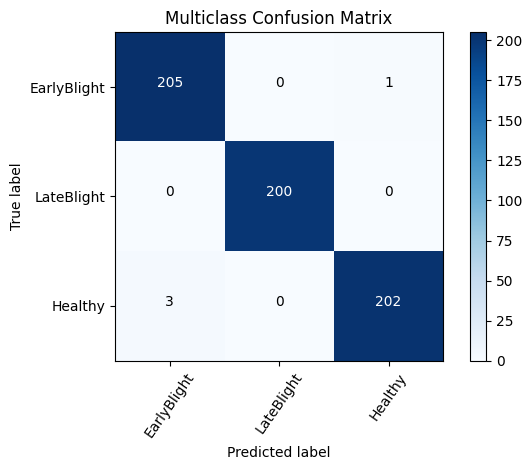

In [ ]:
Y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['EarlyBlight', 'LateBlight','Healthy']
plot_confusion_matrix(cm, cm_plot_label, title ='Multiclass Confusion Matrix')

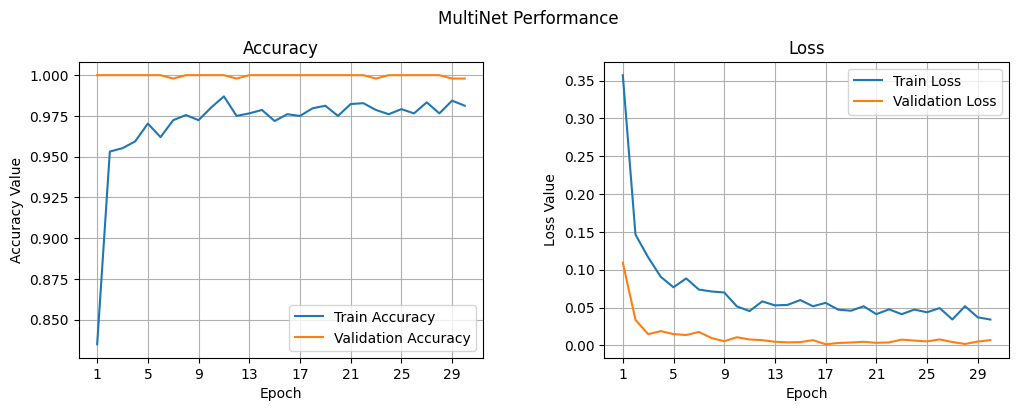

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('MultiNet Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,31))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.grid()
ax1.set_xticks(np.arange(1, 31, 4))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.grid()
ax2.set_xticks(np.arange(1, 31, 4))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [ ]:
pred=model.predict(X_test)
Y_pred = np.argmax(pred, 1)
y_test=np.argmax(Y_test,1)
from sklearn.metrics import classification_report, confusion_matrix
print('Classification Report')
target_names = ['EarlyBlight', 'LateBlight', 'Healthy']
print(classification_report(y_test, Y_pred, target_names=target_names))

20/20 [==============================] - 3s 134ms/step
Classification Report
              precision    recall  f1-score   support

 EarlyBlight       0.99      1.00      0.99       206
  LateBlight       1.00      1.00      1.00       200
     Healthy       1.00      0.99      0.99       205

    accuracy                           0.99       611
   macro avg       0.99      0.99      0.99       611
weighted avg       0.99      0.99      0.99       611



In [ ]:
pred=model.predict(X_test)
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    classification_report,
    precision_score,
    recall_score,
    mean_squared_error,
    mean_absolute_error
)

Y_pred = np.argmax(pred, 1)
y_test=np.argmax(Y_test,1)

accuray = accuracy_score(Y_pred, y_test)
f1 = f1_score(Y_pred, y_test, average="weighted")
precision = precision_score(Y_pred, y_test, average='weighted')
recall = recall_score(Y_pred, y_test, average='weighted')
mse = mean_squared_error(Y_pred, y_test)
mae = mean_absolute_error(Y_pred, y_test)

print("DenseNet201")
print("Accuracy:", accuray)
print("F1 Score:", f1)
print("precision:", precision)
print("recall:", recall)
print("MSE:", mse)
print("MAE:", mae)

20/20 [==============================] - 3s 137ms/step
DenseNet201
Accuracy: 0.9934533551554828
F1 Score: 0.9934535877018329
precision: 0.9934853675201617
recall: 0.9934533551554828
MSE: 0.02618657937806874
MAE: 0.01309328968903437


In [ ]:
pred=model.predict(X_test)
Y_pred = np.argmax(pred, 1)
Y_test=np.argmax(Y_test,1)

20/20 [==============================] - 3s 135ms/step


In [ ]:
import numpy as np
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_pred, pos_label=2)
auc=metrics.auc(fpr, tpr)
auc

0.9878469301934398

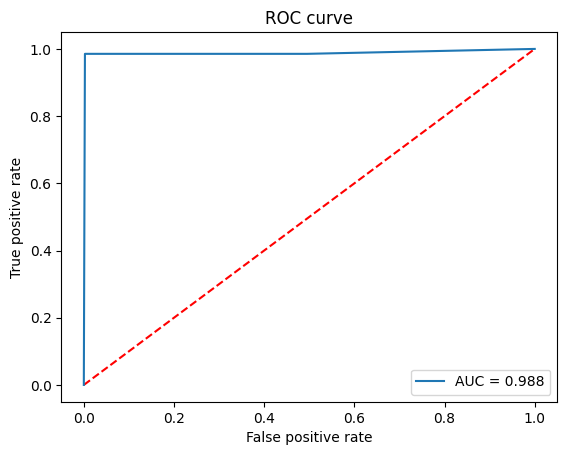

In [ ]:
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()
